# Metastatic Cell Lines DESeq Analysis

In [1]:
import pandas as pd
import numpy as np
import pymongo
import os
import pysam
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels
import seaborn as sns
import random
import re
import json as js
import warnings
warnings.filterwarnings("ignore")
import rpy2.ipython
%load_ext rpy2.ipython

In [2]:
%%R 
library(DESeq2)
library(EnhancedVolcano)

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int

## Load Counts

In [3]:
with open('data/counts/cell_lines_loci_counts.json', 'r') as f:
    sample_loci = js.load(f)
    f.close()

In [4]:
sig_brca_sig_cl_df = pd.read_csv("results/thresholded_oncRNAs.bed", header=None, sep="\t")

In [5]:
met_par_counts = {}
for cell_line, loci_dict in sample_loci.items():
    if "CN34" in cell_line or "LM1a" in cell_line:
        met_par_counts[cell_line] = loci_dict
len(met_par_counts)

4

In [6]:
sig_loci_counts = {} #Use the raw counts
for locus in sig_brca_sig_cl_df[3]:
    sig_loci_counts[locus] = {} 
    for cell_line, loci_dict in met_par_counts.items():
        if locus in loci_dict:
            sig_loci_counts[locus][cell_line] = loci_dict[locus]
        else:
            sig_loci_counts[locus][cell_line] = 0

In [7]:
met_par_cm = pd.DataFrame(sig_loci_counts).T
met_par_cm = met_par_cm[met_par_cm.sum(axis=1) > 0]
met_par_cm = met_par_cm.sort_index(axis=1)
met_par_cm.head()

,CN34_1_cell_S27,CN34_2_cell_S38,LM1a_1_cell_S28,LM1a_2_cell_S39
chr7:13735449-13735471:-,1,0,0,0
chr11:112396454-112396473:+,3,2,1,3
chr12:71664021-71664096:+,0,2,2,0
chrX:127317121-127317153:-,0,1,25,16
chrX:127317160-127317210:+,0,4,17,15


In [8]:
coldata = pd.DataFrame({"condition": ["Par", "Par", "Met", "Met", "Met", "Met", "Par", "Par"], 
                        "type":["single_read", "single_read", "single_read", "single_read", "single_read", "single_read", "single_read", "single_read"],
                       "background":["CN34", "CN34", "CN34", "CN34", "MDA231", "MDA231", "MDA231", "MDA231"]})
coldata.index=met_par_cm.columns
coldata

ValueError: Length mismatch: Expected axis has 8 elements, new values have 4 elements

In [9]:
coldata = pd.DataFrame({"condition": ["Par", "Par", "Met", "Met"], 
                        "type":["single_read", "single_read", "single_read", "single_read"]})
coldata.index=met_par_cm.columns
coldata

,condition,type
CN34_1_cell_S27,Par,single_read
CN34_2_cell_S38,Par,single_read
LM1a_1_cell_S28,Met,single_read
LM1a_2_cell_S39,Met,single_read


In [10]:
%%R -i coldata,met_par_cm
dds <- DESeqDataSetFromMatrix(countData = met_par_cm, colData = coldata, design = ~ condition)
dds <- DESeq(dds)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [11]:
%%R -o dds_res
dds_res <- as.data.frame(results(dds, contrast=c("condition", "Met", "Par"), tidy=TRUE))
dds_res <- dds_res[!is.na(dds_res$padj),]

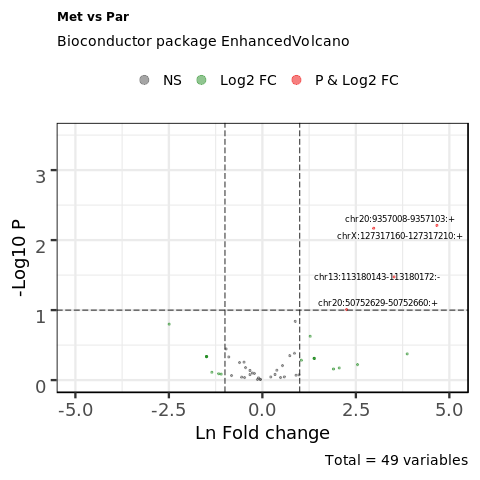

In [12]:
%%R
pdf('figures/metvparDE.pdf')
p <- EnhancedVolcano(dds_res, lab = dds_res$row, x= "log2FoldChange", xlab="Ln Fold change",
                          y="pvalue", ylab="-Log10 P", title= "Met vs Par",
                          titleLabSize = 12, border = "full", pCutoff = 0.1, FCcutoff=1,
                          xlim = c(-5,5), ylim=c(0,3.5), drawConnectors = TRUE, 
)
print(p)
dev.off()
p

In [13]:
sig_res = dds_res[dds_res["pvalue"] < 0.1]

In [14]:
met_par_cm.loc[sig_res["row"]]

,CN34_1_cell_S27,CN34_2_cell_S38,LM1a_1_cell_S28,LM1a_2_cell_S39
chrX:127317121-127317153:-,0,1,25,16
chrX:127317160-127317210:+,0,4,17,15
chr13:113180143-113180172:-,0,1,7,5
chr20:50752629-50752660:+,1,1,6,4
chr20:9357008-9357103:+,1,0,17,10


# Conclusion
Just comparing CN34 and LM1 cell lines, we see some upregulated oncRNAs in the metastatic cell line.